## Pair dispersion

### Plots generated for each deployment

Taking data from `/data/drifters/spot_classified/` and chooding one date of deployment, this script generates the plots of pair dispersion and pair diffusivity

Requires `pastax` library

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair
import pandas as pd

import json
import os
import glob
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.gridded import Gridded
from pastax.trajectory import Location, Trajectory
from pastax.utils import distance_on_earth, meters_to_degrees

In [3]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=12)
rc("axes", labelsize=12)
rc("xtick", labelsize=12)
rc("ytick", labelsize=12)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [4]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [5]:
base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"

In [8]:
spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

In [9]:
spot_l2_df

,deploy_time,drifter_id,traj_id,time,lat,lon,u,v
0,2025-05-12 12:00:00,0-4496232,0,2025-05-13 20:00:00,59.148482,-16.531848,-0.121536,-0.071187
1,2025-05-12 12:00:00,0-4496232,0,2025-05-13 21:00:00,59.146180,-16.539512,-0.127936,-0.063926
2,2025-05-12 12:00:00,0-4496232,0,2025-05-13 22:00:00,59.144347,-16.547983,-0.134340,-0.056664
3,2025-05-12 12:00:00,0-4496232,0,2025-05-13 23:00:00,59.142514,-16.556454,-0.134347,-0.056664
4,2025-05-12 12:00:00,0-4496232,0,2025-05-14 00:00:00,59.140681,-16.564924,-0.141654,-0.068397
...,...,...,...,...,...,...,...,...
18593,2025-05-30 20:40:00,0-4498294,188,2025-07-28 07:00:00,41.110247,1.328618,-0.025629,-0.013426
18594,2025-05-30 20:40:00,0-4498294,188,2025-07-28 08:00:00,41.109915,1.327369,-0.031861,0.008269
18595,2025-05-30 20:40:00,0-4498294,188,2025-07-28 09:00:00,41.110782,1.325883,-0.032446,0.038656
18596,2025-05-30 20:40:00,0-4498294,188,2025-07-28 10:00:00,41.112416,1.324583,-0.060421,0.044030


### Classify by deployment date

In [15]:
from datetime import date

spot_l2_df['deploy_date'] = pd.to_datetime(spot_l2_df['deploy_time']).dt.date

drifters_by_date = spot_l2_df.groupby('deploy_date')['drifter_id'].unique()

date_deployment_1 = date(2025, 5, 12)
drifters_deployment_1 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_1]['drifter_id'].unique()

In [116]:
drifters_deployment_1

array(['0-4496232', '0-4496686', '0-4496931', '0-4498291', '0-4498293'],
      dtype=object)

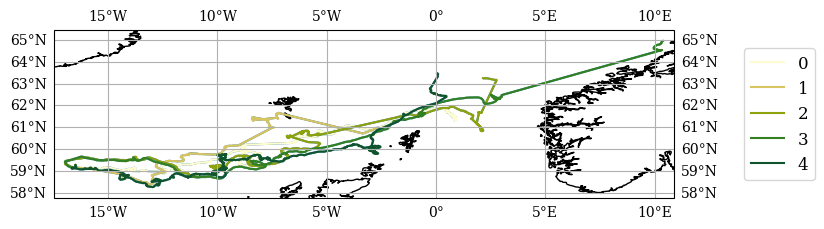

In [58]:
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection

def add_lc(subset, min_lat, max_lat, min_lon, max_lon):
    lon = subset["lon"].to_numpy()
    lat = subset["lat"].to_numpy()

    segments = np.column_stack([lon[:-1], lat[:-1], lon[1:], lat[1:],]).reshape(-1, 2, 2)

    lc = LineCollection(segments, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    if np.min(lat) < min_lat:
        min_lat = np.min(lat)
    if np.max(lat) > max_lat:
        max_lat = np.max(lat)
    if np.min(lon) < min_lon:
        min_lon = np.min(lon)
    if np.max(lon) > max_lon:
        max_lon = np.max(lon)

    return min_lat, max_lat, min_lon, max_lon


fig, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

min_lat = np.inf
max_lat = -np.inf
min_lon = np.inf
max_lon = -np.inf

for i in range(len(drifters_deployment_1)):

    drifter_id = drifters_deployment_1[i]
    df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

    min_lat, max_lat, min_lon, max_lon = add_lc(df, min_lat, max_lat, min_lon, max_lon)

    plt.plot(df.lon.values, df.lat.values, c = cmap(i/len(drifters_deployment_1)), label=str(i))
    #plt.plot(df.lon.values, df.lat.values, '.', c=cmap(i/len(drifters_deployment_1)))

ax.set_xlim([min_lon - .5, max_lon + .5])
ax.set_ylim([min_lat - .5, max_lat + .5])

ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()


### Generate `pastax` trajectory

In [59]:
traj_1_list = []

for i in range(len(drifters_deployment_1)):

    drifter_id = drifters_deployment_1[i]
    df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

    traj = Trajectory.from_array(
        jnp.stack((jnp.asarray(df['lat']), jnp.asarray(df['lon'])), axis=-1), 
        jnp.asarray(np.asarray(df['time']).astype("datetime64[s]").astype(int))
    )

    traj_1_list.append(traj)

    trajs_times = []

traj_1_times = []
for traj in traj_1_list:
    traj_1_times.append(np.asarray(traj.times.value).astype("datetime64[s]"))

In [60]:
#drifter_names = glob.glob(os.path.join(trajectories_path, '*.json'))

#traj_list, trajs_times = create_trajectories_and_times_list(trajectories_path, start_time=start_time)

Interpolate in time

In [61]:
start_time = np.datetime64("2025-05-12T06:00:00")
ts = np.arange(start_time, np.datetime64('now'), np.timedelta64(30,'m'))

dt = np.diff(ts)[0] # in seconds
dt = dt.astype('float')

Create a mask to know which drifters are transmitting close to the times we want to interpolate. The black areas indicate the times when we have experimental data.

Takes some time (5m40). Can be improved.

In [64]:
masks_time = create_mask_trajectories(traj_1_list, traj_1_times, ts)

Text(0.5, 0, 'time idx')

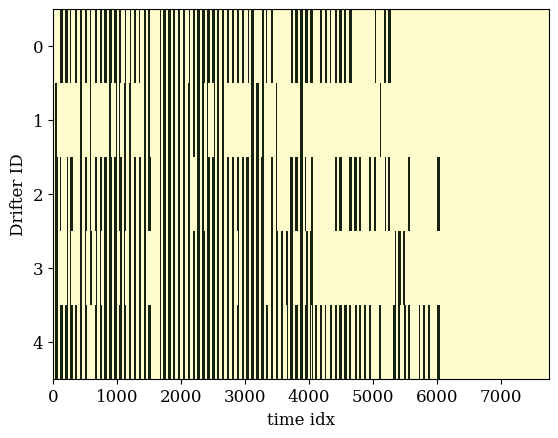

In [65]:
plt.figure()
plt.imshow(masks_time, aspect='auto', interpolation='none', cmap=cmap)
plt.ylabel('Drifter ID')
plt.xlabel('time idx')

## It works way better than before!

Interpolate in time

In [66]:
interpolated_trajs = temporal_interpolation(traj_1_list, masks_time, ts, traj_1_times)

### Dispersion metrics

#### Pair diffusivity

$$ K_{ij} = \frac{1}{2}\frac{d}{dt} (D_{ij}^2) $$
  

In [ ]:
Ds, Ks, mask_pair = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs, masks_time, dt)

(1, np.float64(176.40270338727962))

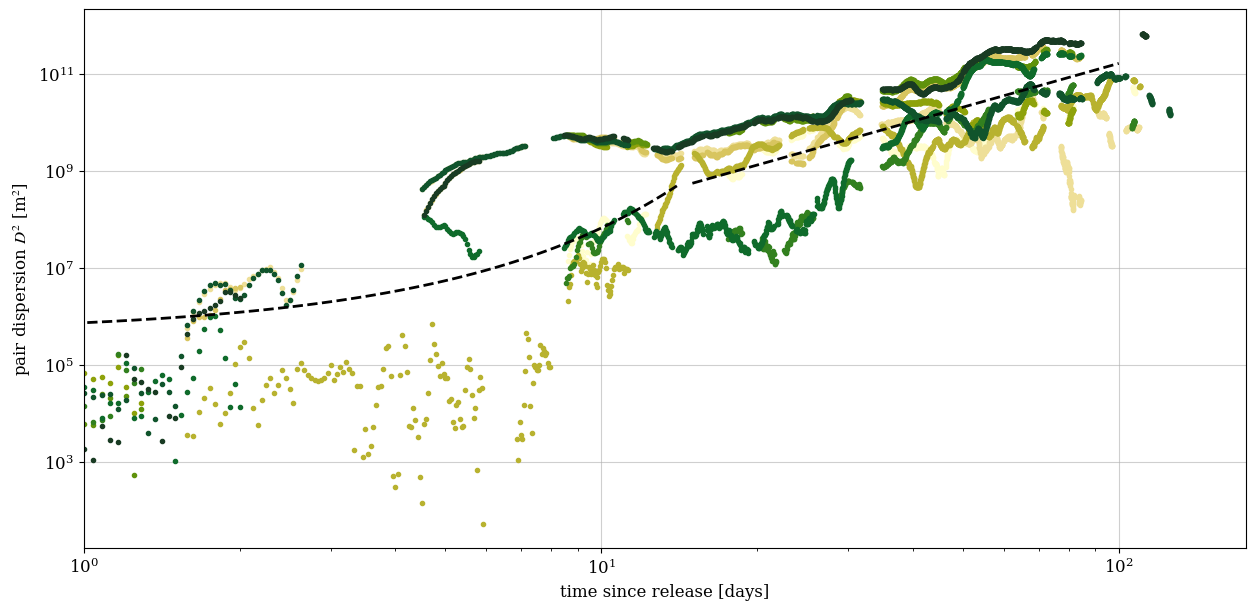

In [75]:
N = len(interpolated_trajs)
N_pairs = int(N*(N-1)/2)

markers_list = Line2D.filled_markers

plt.figure(figsize=(15,7))
for i in range(N_pairs):
    #if i==6 or i==9 or i==5:
    # if i==6:
    #    pass
    #else:
    t_pair = ts[mask_pair[i]]
    t_pair = t_pair[:-1].astype(int) - start_time.astype(int)
    t_pair_days = t_pair/(24*60*60)
    D_km = Ds[i]/1000
    #plt.plot(t_pair_days, D_km**2, c = cmap(i/N_pairs), marker=markers_list[i+1], markersize = 10, linestyle='', label=str(i))
    plt.plot(t_pair_days, Ds[i]**2, c = cmap(i/N_pairs), marker='o', markersize = 3, linestyle='', label=str(i))


a = 2
t_exp = np.linspace(0, 14, 100)
plt.plot(t_exp, np.exp(t_exp/a)/np.exp(-13), 'k--', linewidth=2)

#t_ballistic = np.linspace(15, 29, 100)
#plt.plot(t_ballistic, t_ballistic**2/np.exp(-15), 'k--', linewidth=2)

t_richardson = np.linspace(15, 100, 100)
plt.plot(t_richardson, t_richardson**3/np.exp(-12), 'k--', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.6)
plt.rcParams['legend.title_fontsize'] = 20
# plt.legend(title = 'pairs', fontsize=20, loc='upper right', bbox_to_anchor=(1.15, 1))
plt.ylabel('pair dispersion $D^2$ [m$^2$]')
plt.xlabel('time since release [days]') 
plt.xlim(xmin=1)
    

Text(0, 0.5, 'drifter diffusivity $K$ [m$^2$/s]')

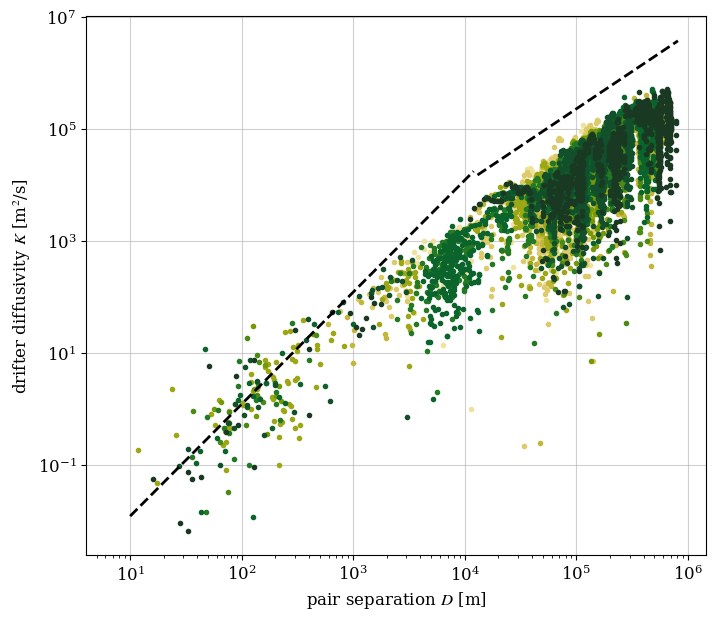

In [80]:
plt.figure( figsize=(8,7))
for i in range(N_pairs):
    plt.plot(Ds[i], Ks[i], c = cmap((i+1)/(N_pairs+1)), marker='o', markersize = 3, linestyle='',label=str(i))
    #print(markers_list[0][i])
max_dist = np.max([np.max(Ds[i]) for i in range(len(Ds))])
# d = np.arange(1, max_dist, 1000)

d_exp = np.linspace(10, 12000, 100)
plt.plot(d_exp, d_exp**2/np.exp(9), 'k--', linewidth = 2, label='exponential regime')

d_richardson = np.linspace(13000, max_dist, 100)
plt.plot(d_richardson, d_richardson**(4/3)/np.exp(3), 'k--', linewidth = 2, label='Richardson regime')

plt.xscale("log")
plt.yscale("log")

plt.grid(alpha=0.6)
#plt.legend(title = 'pairs', loc='upper right', bbox_to_anchor=(1.1, 1.))
#plt.legend()
#plt.xlim(xmin=1)

plt.xlabel('pair separation $D$ [m]')
plt.ylabel('drifter diffusivity $K$ [m$^2$/s]')


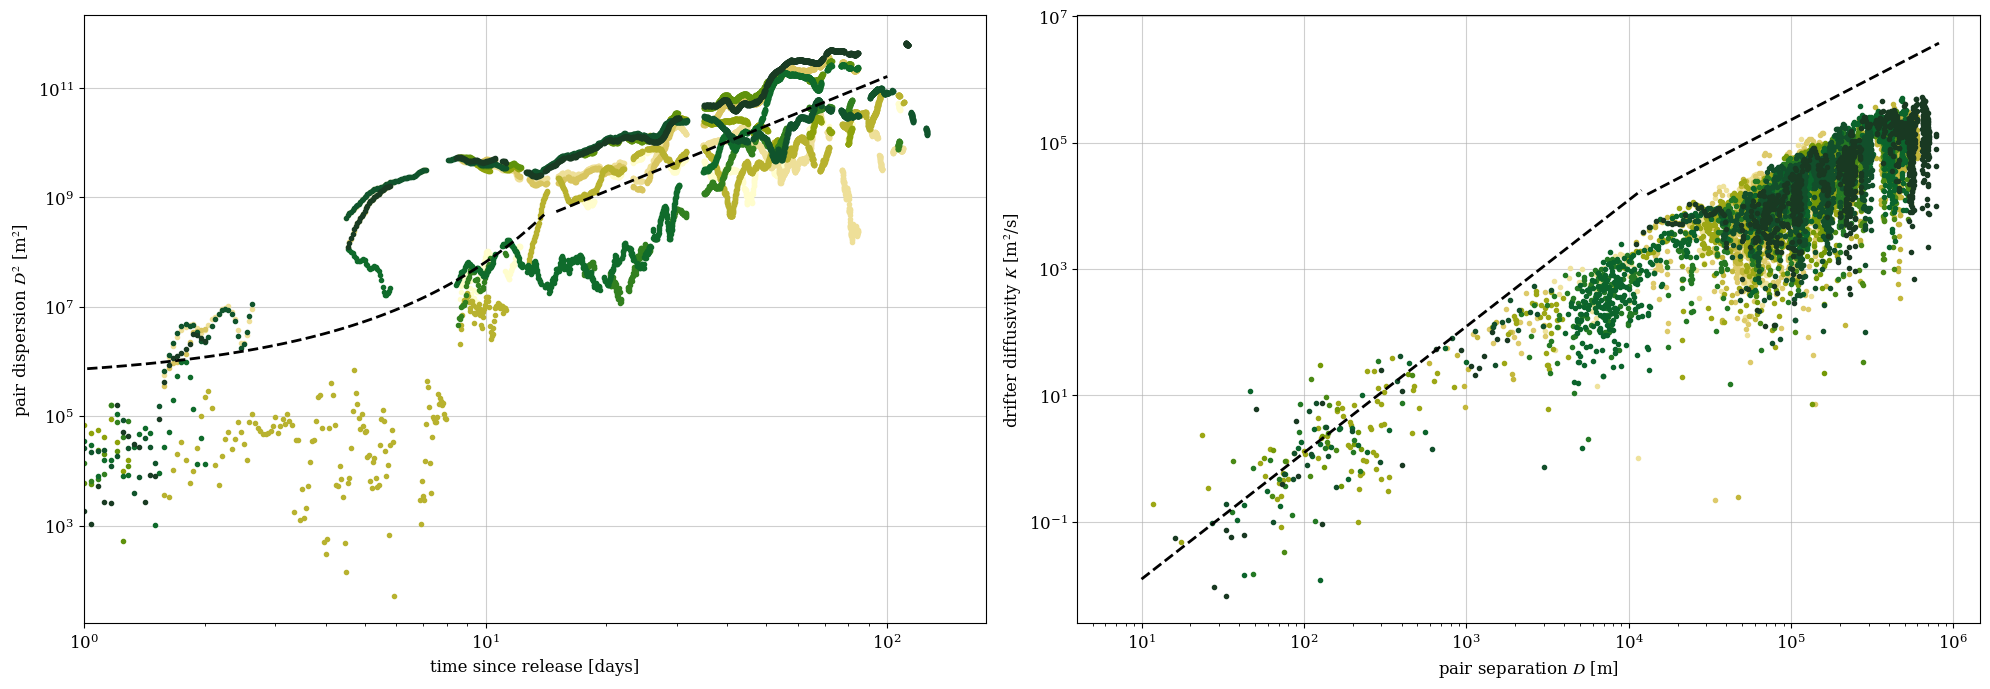

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have all the necessary variables defined:
# N, N_pairs, ts, mask_pair, start_time, Ds, Ks, cmap, etc.

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# First subplot - Pair dispersion vs time
for i in range(N_pairs):
    t_pair = ts[mask_pair[i]]
    t_pair = t_pair[:-1].astype(int) - start_time.astype(int)
    t_pair_days = t_pair/(24*60*60)
    ax1.plot(t_pair_days, Ds[i]**2, c=cmap(i/N_pairs), marker='o', 
             markersize=3, linestyle='', label=str(i))

a = 2
t_exp = np.linspace(0, 14, 100)
ax1.plot(t_exp, np.exp(t_exp/a)/np.exp(-13), 'k--', linewidth=2)
t_richardson = np.linspace(15, 100, 100)
ax1.plot(t_richardson, t_richardson**3/np.exp(-12), 'k--', linewidth=2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(alpha=0.6)
ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
ax1.set_xlabel('time since release [days]')
ax1.set_xlim(xmin=1)

# Second subplot - Diffusivity vs pair separation
for i in range(N_pairs):
    ax2.plot(Ds[i], Ks[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
             markersize=3, linestyle='', label=str(i))

max_dist = np.max([np.max(Ds[i]) for i in range(len(Ds))])
d_exp = np.linspace(10, 12000, 100)
ax2.plot(d_exp, d_exp**2/np.exp(9), 'k--', linewidth=2, 
         label='exponential regime')
d_richardson = np.linspace(13000, max_dist, 100)
ax2.plot(d_richardson, d_richardson**(4/3)/np.exp(3), 'k--', linewidth=2, 
         label='Richardson regime')

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(alpha=0.6)
ax2.set_xlabel('pair separation $D$ [m]')
ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.tight_layout()
plt.show()

## Finite-Scale Lyapunov Exponents (FSLE)

$$ \lambda(D) = \frac{\ln r}{\tau(D)}$$

where $D$ is the pair separation, and $\tau$ is the shortest time required for $D$ to increase by a factor of $r>1$

In [106]:
import numpy as np

def calculate_fsle(D, t, r=2.0, D_bins=None):
    """
    Calculate Finite-Scale Lyapunov Exponent (FSLE).
    
    Parameters:
    -----------
    D : array-like
        Time series of pair separation distances
    t : array-like
        Time stamps corresponding to each separation measurement
    r : float
        Growth factor (default: 2.0)
    D_bins : array-like, optional
        Specific initial scales to compute FSLE at (e.g., logarithmically spaced)
    
    Returns:
    --------
    lambda_values : array
        FSLE values for each growth event
    D_initial : array
        Initial separation distances for each event
    tau_values : array
        Growth times for each event
    """
    D = np.asarray(D)
    t = np.asarray(t)
    
    if D_bins is not None:
        # Calculate FSLE at specific scales
        lambda_values = []
        D_initial = []
        tau_values = []
        
        for D0_target in D_bins:
            # Find first time D exceeds D0_target
            idx_start = np.where(D >= D0_target)[0]
            if len(idx_start) == 0:
                continue
            
            i = idx_start[0]
            D0 = D[i]
            t0 = t[i]
            target = D0 * r
            
            # Find when separation exceeds target
            idx_end = np.where(D[i:] >= target)[0]
            
            if len(idx_end) > 0:
                j = idx_end[0]
                tau = t[i + j] - t0
                
                if tau > 0:
                    lam = np.log(r) / tau
                    lambda_values.append(lam)
                    D_initial.append(D0)
                    tau_values.append(tau)
        
        return np.array(lambda_values), np.array(D_initial), np.array(tau_values)
    
    else:
        # Original algorithm: consecutive doublings
        lambda_values = []
        D_initial = []
        tau_values = []
        
        i = 0
        while i < len(D) - 1:
            D0 = D[i]
            t0 = t[i]
            target = D0 * r
            
            # Find when separation exceeds target
            idx = np.where(D[i:] >= target)[0]
            
            if len(idx) > 0:
                j = idx[0]
                tau = t[i + j] - t0
                
                if tau > 0:
                    lam = np.log(r) / tau
                    lambda_values.append(lam)
                    D_initial.append(D0)
                    tau_values.append(tau)
                    i += j
                else:
                    i += 1
            else:
                break
        
        return np.array(lambda_values), np.array(D_initial), np.array(tau_values)

Text(0, 0.5, '$K$ [days$^{-1}$]')

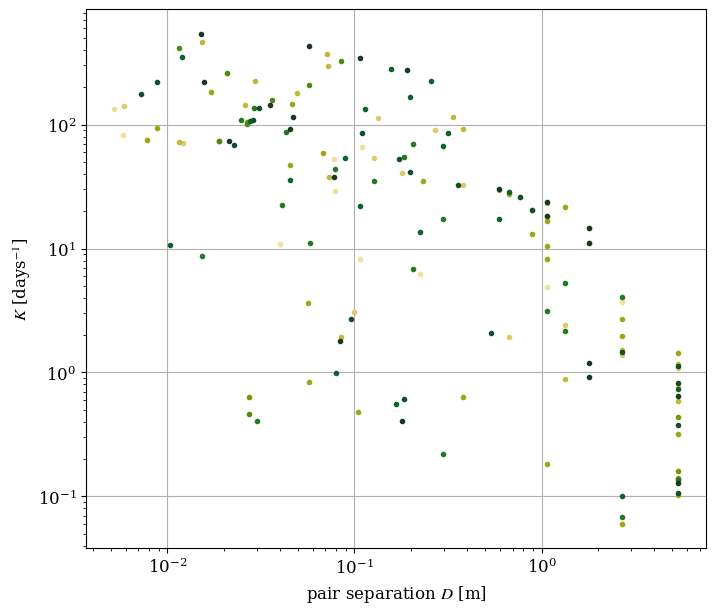

In [ ]:
plt.figure( figsize=(8,7))
for i in range(N_pairs):
    t_pair = ts[mask_pair[i]]
    t_pair = t_pair[:-1].astype(int) - start_time.astype(int)
    t_pair_days = t_pair/(24*60*60)
    D_km = Ds[i]/1000
    lam, D0, tau = calculate_fsle(D_km, t_pair_days, r=1.25)
    plt.plot(lam, D0, c = cmap((i+1)/(N_pairs+1)), marker='o', markersize = 3, linestyle='',label=str(i))

plt.xscale("log")
plt.yscale("log")
plt.grid()

plt.xlabel('pair separation $D$ [m]')
plt.ylabel('$K$ [days$^{-1}$]')